In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import time
import tqdm
from datetime import datetime
from google.cloud.logging import DESCENDING, Client
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.family'] = 'monospace'

read delivered payloads for the last 24 hours from the db.

```
psql -p 5433 "host=0.0.0.0 sslmode=disable dbname=defaultdb user=readonly" -t -c "select slot,block_hash,proposer_pubkey,inserted_at from mainnet_payload_delivered where slot>=6287355;" -o cancel/delivered-apr24.txt
```

slot range $[6287356,6294551]$.

# delivered payloads

In [2]:
# read data from file.
dlvd = pd.read_csv('delivered-apr24.txt', delimiter='|', names=['slot','block_hash','proposer_pubkey','inserted_at'])
dlvd['inserted_at'] = pd.to_datetime(dlvd['inserted_at'], format="%Y-%m-%d%H:%M:%S.%f")
dlvd['slot_boundary'] = pd.to_datetime(1606824023 + dlvd['slot'] * 12, unit='s')
dlvd.head()

,slot,block_hash,proposer_pubkey,inserted_at,slot_boundary
0,6287356,0x0f58d3a1b835ae053388804701180f246611b8939572...,0x8656dab6bae6f46037862a8954af4f72d97b63866f65...,2023-04-23 17:51:37.291059,2023-04-23 17:51:35
1,6287363,0xd8c3792a70a517ee58df86a78d49a28654510038afe9...,0x8c9dd8f50a31f51a0525d1a53697716c838c45060bb3...,2023-04-23 17:53:01.124746,2023-04-23 17:52:59
2,6287371,0xa398751b66f4abe3fc09c244faa35c7d5160492b36b1...,0x9076ea0749534137aa85a41bedd3e55a008d8e8a00eb...,2023-04-23 17:54:37.072391,2023-04-23 17:54:35
3,6287375,0x17518a7788f5683c516e1bffa1bd9c5d2d833e527730...,0xb9845cceda7505b05ad2edfd474805d66bd1ecc4494e...,2023-04-23 17:55:26.290921,2023-04-23 17:55:23
4,6287376,0x91037fcbfd76866cca8c2e60c0a021c956545de16998...,0x8ab0403a2931163a618d066d38364969841d785f0503...,2023-04-23 17:55:37.285840,2023-04-23 17:55:35


# getPayload calls from GCP.

NOTE: we are getting just the first call to getPayload.

/usr/local/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [ ]:
getPayloads = pd.DataFrame(columns=['slot', 'ip', 'ua', 'reqTime'])

In [20]:
for v in dlvd.iterrows():
    if v[1]['slot'] < 6287906:
        time.sleep(0.5)
        # get successful getPayload calls.
        inAt = v[1]['inserted_at']
        print('querying logs for slot {} inserted at {}'.format(v[1]['slot'], v[1]['inserted_at']), end='\r')
        gpFilter = '"https://relay.ultrasound.money/eth/v1/builder/blinded_block" ' + \
                   'AND timestamp>=' + '\"' + (inAt - pd.Timedelta('12s')).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\" ' + \
                   'AND timestamp<=' + '\"' + (inAt).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\"'
        entries = False
        for e in client.list_entries(filter_=gpFilter):
            entries = True
            out = {}
            out['slot'] = v[1]['slot']
            out['ip'] = e.http_request['remoteIp']
            out['ua'] = e.http_request['userAgent']
            out['reqTime'] = e.timestamp 
            getPayloads = getPayloads.append(out, ignore_index=True)
        if not entries:
            print("\n *** no entries found for slot: {}".format(v[1]['slot']))
            print(gpFilter)

In [69]:
gpFilter

'"https://relay.ultrasound.money/eth/v1/builder/blinded_block" AND timestamp>="2023-04-23T19:41:13.188592Z" AND timestamp<="2023-04-23T19:41:25.188592Z"'

In [32]:
getPayloads = getPayloads.sort_values(['slot', 'reqTime'], ascending=[True, True])
getPayloads = getPayloads.drop_duplicates(['slot'])
getPayloads.reset_index(drop=True)
getPayloads.head()

,slot,ip,ua,reqTime
2782,6287356,34.77.3.1,Go-http-client/1.1,2023-04-23 17:51:35.004310+00:00
2783,6287363,89.149.218.12,mev-boost/v1.5.0 Lighthouse/v4.1.0-693886b,2023-04-23 17:52:59.508839+00:00
2784,6287371,57.128.32.19,mev-boost/v1.5.0,2023-04-23 17:54:35.524251+00:00
2785,6287375,158.140.135.239,mev-boost/v1.5.0 Prysm/v4.0.3/f4681fde1946a86c...,2023-04-23 17:55:23.986769+00:00
2786,6287376,3.74.185.146,Go-http-client/1.1,2023-04-23 17:55:35.012735+00:00


In [33]:
len(set(getPayloads.slot)), len(dlvd), len(getPayloads.slot)

(2658, 2658, 2658)

In [35]:
getPayloadsFull = pd.merge(getPayloads, dlvd, on='slot')
getPayloadsFull

,slot,ip,ua,reqTime,block_hash,proposer_pubkey,inserted_at,slot_boundary
0,6287356,34.77.3.1,Go-http-client/1.1,2023-04-23 17:51:35.004310+00:00,0x0f58d3a1b835ae053388804701180f246611b8939572...,0x8656dab6bae6f46037862a8954af4f72d97b63866f65...,2023-04-23 17:51:37.291059,2023-04-23 17:51:35
1,6287363,89.149.218.12,mev-boost/v1.5.0 Lighthouse/v4.1.0-693886b,2023-04-23 17:52:59.508839+00:00,0xd8c3792a70a517ee58df86a78d49a28654510038afe9...,0x8c9dd8f50a31f51a0525d1a53697716c838c45060bb3...,2023-04-23 17:53:01.124746,2023-04-23 17:52:59
2,6287371,57.128.32.19,mev-boost/v1.5.0,2023-04-23 17:54:35.524251+00:00,0xa398751b66f4abe3fc09c244faa35c7d5160492b36b1...,0x9076ea0749534137aa85a41bedd3e55a008d8e8a00eb...,2023-04-23 17:54:37.072391,2023-04-23 17:54:35
3,6287375,158.140.135.239,mev-boost/v1.5.0 Prysm/v4.0.3/f4681fde1946a86c...,2023-04-23 17:55:23.986769+00:00,0x17518a7788f5683c516e1bffa1bd9c5d2d833e527730...,0xb9845cceda7505b05ad2edfd474805d66bd1ecc4494e...,2023-04-23 17:55:26.290921,2023-04-23 17:55:23
4,6287376,3.74.185.146,Go-http-client/1.1,2023-04-23 17:55:35.012735+00:00,0x91037fcbfd76866cca8c2e60c0a021c956545de16998...,0x8ab0403a2931163a618d066d38364969841d785f0503...,2023-04-23 17:55:37.285840,2023-04-23 17:55:35
...,...,...,...,...,...,...,...,...
2653,6294530,167.99.164.32,mev-boost/v1.5.0,2023-04-24 17:46:24.047788+00:00,0x7041bca1f03039be5eb000e7cd55bb9a0e8fc2b9eb26...,0xa1fca56e908f2a3610cc070b6a57d373687b428b1a09...,2023-04-24 17:46:25.658167,2023-04-24 17:46:23
2654,6294531,35.88.134.71,mev-boost/v1.5.0 Go-http-client/1.1,2023-04-24 17:46:36.435164+00:00,0x18bcbf52e094cf1d598c2d5c560db6160774d0f03387...,0xa62a2c65c8e6a41b258c50cbff2d8f683af02b1145df...,2023-04-24 17:46:38.090339,2023-04-24 17:46:35
2655,6294549,34.82.140.105,mev-boost/v1.5.0 okhttp/4.10.0,2023-04-24 17:50:11.566013+00:00,0x1c6d90901205d0c0f7e1a35c375e313cd31713aaf927...,0xa2a207261959aba515f142e26b0f3262083ebf77716f...,2023-04-24 17:50:13.325541,2023-04-24 17:50:11
2656,6294550,20.203.252.23,mev-boost/v1.5.0 okhttp/4.10.0,2023-04-24 17:50:23.533425+00:00,0xb99ce21ca2f7ae186c887a65d940c8f9b77ee408871f...,0x85c7fc170e939c1e1be0deb43bc28cf787263a9c60d9...,2023-04-24 17:50:24.983845,2023-04-24 17:50:23


In [53]:
getPayloadsFull.to_csv('gpFull.csv', index=False)

# getHeader calls from GCP

In [41]:
getHeaders = pd.DataFrame(columns=['slot', 'ip', 'ua', 'reqTime'])

In [43]:
for v in getPayloadsFull.iterrows():
    time.sleep(1)
    # get successful getPayload calls.
    inAt = v[1]['inserted_at']
    print('querying logs for slot {} inserted at {}'.format(v[1]['slot'], v[1]['inserted_at']), end='\r')
    ghFilter = 'resource.type="http_load_balancer" ' + \
               'httpRequest.status=200 ' + \
               '"https://relay.ultrasound.money/eth/v1/builder/header/{}" '.format(v[1]['slot']) + \
               'jsonPayload.remoteIp="{}" '.format(v[1]['ip']) + \
               'AND timestamp>=' + '\"' + (inAt - pd.Timedelta('12s')).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\" ' + \
               'AND timestamp<=' + '\"' + (inAt).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\"'
    entries = False
    for e in client.list_entries(filter_=ghFilter):
        entries = True
        out = {}
        out['slot'] = v[1]['slot']
        out['ip'] = e.http_request['remoteIp']
        out['ua'] = e.http_request['userAgent']
        out['reqTime'] = e.timestamp 
        getHeaders = getHeaders.append(out, ignore_index=True)
    if not entries:
        print("*** no entries found for slot: {}".format(v[1]['slot']), end='\r')

In [67]:
ghFilter

'resource.type="http_load_balancer" httpRequest.status=200 "https://relay.ultrasound.money/eth/v1/builder/header/6294551" jsonPayload.remoteIp="34.249.7.41" AND timestamp>="2023-04-24T17:50:24.994254Z" AND timestamp<="2023-04-24T17:50:36.994254Z"'

In [45]:
len(getHeaders)

2125

In [46]:
getHeaders.to_csv('ghFull.txt', index=False)

In [56]:
getPayloadsFull.head()

,slot,ip,ua,reqTime,block_hash,proposer_pubkey,inserted_at,slot_boundary
0,6287356,34.77.3.1,Go-http-client/1.1,2023-04-23 17:51:35.004310+00:00,0x0f58d3a1b835ae053388804701180f246611b8939572...,0x8656dab6bae6f46037862a8954af4f72d97b63866f65...,2023-04-23 17:51:37.291059,2023-04-23 17:51:35
1,6287363,89.149.218.12,mev-boost/v1.5.0 Lighthouse/v4.1.0-693886b,2023-04-23 17:52:59.508839+00:00,0xd8c3792a70a517ee58df86a78d49a28654510038afe9...,0x8c9dd8f50a31f51a0525d1a53697716c838c45060bb3...,2023-04-23 17:53:01.124746,2023-04-23 17:52:59
2,6287371,57.128.32.19,mev-boost/v1.5.0,2023-04-23 17:54:35.524251+00:00,0xa398751b66f4abe3fc09c244faa35c7d5160492b36b1...,0x9076ea0749534137aa85a41bedd3e55a008d8e8a00eb...,2023-04-23 17:54:37.072391,2023-04-23 17:54:35
3,6287375,158.140.135.239,mev-boost/v1.5.0 Prysm/v4.0.3/f4681fde1946a86c...,2023-04-23 17:55:23.986769+00:00,0x17518a7788f5683c516e1bffa1bd9c5d2d833e527730...,0xb9845cceda7505b05ad2edfd474805d66bd1ecc4494e...,2023-04-23 17:55:26.290921,2023-04-23 17:55:23
4,6287376,3.74.185.146,Go-http-client/1.1,2023-04-23 17:55:35.012735+00:00,0x91037fcbfd76866cca8c2e60c0a021c956545de16998...,0x8ab0403a2931163a618d066d38364969841d785f0503...,2023-04-23 17:55:37.285840,2023-04-23 17:55:35


# join the two

In [2]:
getHeaders = pd.read_csv('ghFull.txt')
getPayloadsFull = pd.read_csv('gpFull.csv')

In [3]:
merged = pd.merge(getHeaders, getPayloadsFull, on=['ip', 'slot'], how='left')
merged.head()

,slot,ip,ua_x,reqTime_x,ua_y,reqTime_y,block_hash,proposer_pubkey,inserted_at,slot_boundary
0,6287363,89.149.218.12,mev-boost/v1.5.0 Lighthouse/v4.1.0-693886b,2023-04-23 17:52:59.224636+00:00,mev-boost/v1.5.0 Lighthouse/v4.1.0-693886b,2023-04-23 17:52:59.508839+00:00,0xd8c3792a70a517ee58df86a78d49a28654510038afe9...,0x8c9dd8f50a31f51a0525d1a53697716c838c45060bb3...,2023-04-23 17:53:01.124746,2023-04-23 17:52:59.000000
1,6287371,57.128.32.19,mev-boost/v1.5.0,2023-04-23 17:54:35.214206+00:00,mev-boost/v1.5.0,2023-04-23 17:54:35.524251+00:00,0xa398751b66f4abe3fc09c244faa35c7d5160492b36b1...,0x9076ea0749534137aa85a41bedd3e55a008d8e8a00eb...,2023-04-23 17:54:37.072391,2023-04-23 17:54:35.000000
2,6287375,158.140.135.239,mev-boost/v1.5.0 Prysm/v4.0.3/f4681fde1946a86c...,2023-04-23 17:55:23.190772+00:00,mev-boost/v1.5.0 Prysm/v4.0.3/f4681fde1946a86c...,2023-04-23 17:55:23.986769+00:00,0x17518a7788f5683c516e1bffa1bd9c5d2d833e527730...,0xb9845cceda7505b05ad2edfd474805d66bd1ecc4494e...,2023-04-23 17:55:26.290921,2023-04-23 17:55:23.000000
3,6287363,89.149.218.12,mev-boost/v1.5.0 Lighthouse/v4.1.0-693886b,2023-04-23 17:52:59.224636+00:00,mev-boost/v1.5.0 Lighthouse/v4.1.0-693886b,2023-04-23 17:52:59.508839+00:00,0xd8c3792a70a517ee58df86a78d49a28654510038afe9...,0x8c9dd8f50a31f51a0525d1a53697716c838c45060bb3...,2023-04-23 17:53:01.124746,2023-04-23 17:52:59.000000
4,6287371,57.128.32.19,mev-boost/v1.5.0,2023-04-23 17:54:35.214206+00:00,mev-boost/v1.5.0,2023-04-23 17:54:35.524251+00:00,0xa398751b66f4abe3fc09c244faa35c7d5160492b36b1...,0x9076ea0749534137aa85a41bedd3e55a008d8e8a00eb...,2023-04-23 17:54:37.072391,2023-04-23 17:54:35.000000


In [4]:
merged = merged.rename(columns={'reqTime_x': 'header_req', 
                                'reqTime_y': 'payload_req',
                                'ua_x': 'header_ua',  
                                'ua_y': 'payload_ua',
                       })
merged = merged[['slot', 'ip', 'header_ua', 'payload_ua', 'slot_boundary', 'header_req', 'payload_req', 'block_hash', 'proposer_pubkey']]

for col in ['slot_boundary', 'header_req', 'payload_req']:
    merged[col] = pd.to_datetime(merged[col]).dt.strftime("%Y-%m-%d %H:%M:%S.%f")
    merged[col] = pd.to_datetime(merged[col])
merged = merged.drop_duplicates(['header_req'])
merged = merged.sort_values(['slot', 'header_req'], ascending=[True, True])
merged.reset_index(drop=True)
merged.head()

,slot,ip,header_ua,payload_ua,slot_boundary,header_req,payload_req,block_hash,proposer_pubkey
0,6287363,89.149.218.12,mev-boost/v1.5.0 Lighthouse/v4.1.0-693886b,mev-boost/v1.5.0 Lighthouse/v4.1.0-693886b,2023-04-23 17:52:59,2023-04-23 17:52:59.224636,2023-04-23 17:52:59.508839,0xd8c3792a70a517ee58df86a78d49a28654510038afe9...,0x8c9dd8f50a31f51a0525d1a53697716c838c45060bb3...
1,6287371,57.128.32.19,mev-boost/v1.5.0,mev-boost/v1.5.0,2023-04-23 17:54:35,2023-04-23 17:54:35.214206,2023-04-23 17:54:35.524251,0xa398751b66f4abe3fc09c244faa35c7d5160492b36b1...,0x9076ea0749534137aa85a41bedd3e55a008d8e8a00eb...
2,6287375,158.140.135.239,mev-boost/v1.5.0 Prysm/v4.0.3/f4681fde1946a86c...,mev-boost/v1.5.0 Prysm/v4.0.3/f4681fde1946a86c...,2023-04-23 17:55:23,2023-04-23 17:55:23.190772,2023-04-23 17:55:23.986769,0x17518a7788f5683c516e1bffa1bd9c5d2d833e527730...,0xb9845cceda7505b05ad2edfd474805d66bd1ecc4494e...
6,6287378,20.203.252.23,mev-boost/v1.5.0 okhttp/4.10.0,mev-boost/v1.5.0 okhttp/4.10.0,2023-04-23 17:55:59,2023-04-23 17:55:59.122244,2023-04-23 17:55:59.540486,0xb34b74c7fdf4a74110ad4d35ab05da18855645522258...,0x95d75b5910790cb42f7947ab14c679267e8f73be1a77...
7,6287380,34.249.7.41,mev-boost/v1.5.0 Prysm/v4.0.2/f4681fde1946a86c...,mev-boost/v1.5.0 Prysm/v4.0.2/f4681fde1946a86c...,2023-04-23 17:56:23,2023-04-23 17:56:23.347438,2023-04-23 17:56:23.565121,0x5b0dbb355fcdce011e2624312aa4420fe951a69f2509...,0x971860fbd43fff1cb91ac0a35bc4c7efd6de0b12331e...


In [5]:
len(merged), len(set(merged.slot))

(2122, 2121)

In [6]:
merged.to_csv('merged.txt', index=False)

# getHeader getPayload figure

In [14]:
merged = pd.read_csv('merged.txt')
merged['slot_boundary'] = pd.to_datetime(merged['slot_boundary'], format="%Y-%m-%d %H:%M:%S.%f")
merged['header_req'] = pd.to_datetime(merged['header_req'], format="%Y-%m-%d %H:%M:%S.%f")
merged['payload_req'] = pd.to_datetime(merged['payload_req'], format="%Y-%m-%d %H:%M:%S.%f")

In [15]:
merged['ghDiff'] = [(v).total_seconds() for v in merged['header_req'] - merged['slot_boundary']]
merged['gpDiff'] = [(v).total_seconds() for v in merged['payload_req'] - merged['slot_boundary']]
merged['gpGh'] = [(v).total_seconds() for v in merged['payload_req'] - merged['header_req']]
merged.head()

,slot,ip,header_ua,payload_ua,slot_boundary,header_req,payload_req,block_hash,proposer_pubkey,ghDiff,gpDiff,gpGh
0,6287363,89.149.218.12,mev-boost/v1.5.0 Lighthouse/v4.1.0-693886b,mev-boost/v1.5.0 Lighthouse/v4.1.0-693886b,2023-04-23 17:52:59,2023-04-23 17:52:59.224636,2023-04-23 17:52:59.508839,0xd8c3792a70a517ee58df86a78d49a28654510038afe9...,0x8c9dd8f50a31f51a0525d1a53697716c838c45060bb3...,0.224636,0.508839,0.284203
1,6287371,57.128.32.19,mev-boost/v1.5.0,mev-boost/v1.5.0,2023-04-23 17:54:35,2023-04-23 17:54:35.214206,2023-04-23 17:54:35.524251,0xa398751b66f4abe3fc09c244faa35c7d5160492b36b1...,0x9076ea0749534137aa85a41bedd3e55a008d8e8a00eb...,0.214206,0.524251,0.310045
2,6287375,158.140.135.239,mev-boost/v1.5.0 Prysm/v4.0.3/f4681fde1946a86c...,mev-boost/v1.5.0 Prysm/v4.0.3/f4681fde1946a86c...,2023-04-23 17:55:23,2023-04-23 17:55:23.190772,2023-04-23 17:55:23.986769,0x17518a7788f5683c516e1bffa1bd9c5d2d833e527730...,0xb9845cceda7505b05ad2edfd474805d66bd1ecc4494e...,0.190772,0.986769,0.795997
3,6287378,20.203.252.23,mev-boost/v1.5.0 okhttp/4.10.0,mev-boost/v1.5.0 okhttp/4.10.0,2023-04-23 17:55:59,2023-04-23 17:55:59.122244,2023-04-23 17:55:59.540486,0xb34b74c7fdf4a74110ad4d35ab05da18855645522258...,0x95d75b5910790cb42f7947ab14c679267e8f73be1a77...,0.122244,0.540486,0.418242
4,6287380,34.249.7.41,mev-boost/v1.5.0 Prysm/v4.0.2/f4681fde1946a86c...,mev-boost/v1.5.0 Prysm/v4.0.2/f4681fde1946a86c...,2023-04-23 17:56:23,2023-04-23 17:56:23.347438,2023-04-23 17:56:23.565121,0x5b0dbb355fcdce011e2624312aa4420fe951a69f2509...,0x971860fbd43fff1cb91ac0a35bc4c7efd6de0b12331e...,0.347438,0.565121,0.217683


In [8]:
merged[merged['slot']==6289905]

,slot,ip,header_ua,payload_ua,slot_boundary,header_req,payload_req,block_hash,proposer_pubkey,ghDiff,gpDiff,gpGh
758,6289905,34.107.114.88,Go-http-client/1.1,Go-http-client/1.1,2023-04-24 02:21:23,2023-04-24 02:21:17.484358,2023-04-24 02:21:23.011903,0x4d3ec4d3469e0a10b3fad8c6311c4bdf1525d5dce951...,0xb64a41da7477af013e9febc0f1a29eab91c8da6b1d69...,-5.515642,0.011903,5.527545


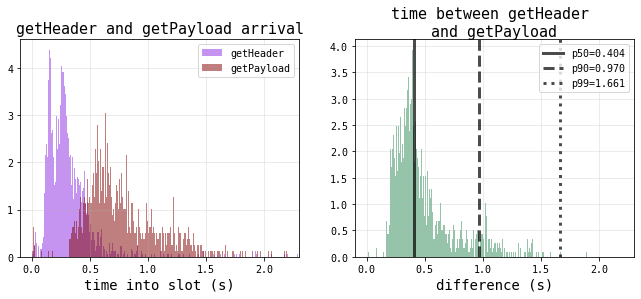

In [20]:
f, axarr = plt.subplots(ncols=2, figsize=(11,4))

ax = axarr[0]
ax.hist(merged['ghDiff'], bins=1000, color='blueviolet', alpha=0.5, cumulative=0, density=True, label='getHeader')
ax.hist(merged['gpDiff'], bins=1000, color='maroon', alpha=0.5, cumulative=0, density=True, label='getPayload')

ax = axarr[1]
ax.hist(merged['gpGh'], bins=1000, color='seagreen', alpha=0.5, cumulative=0, density=True)
linestyle = ['-', '--', ':']
percs = [(int(i*100), np.quantile(merged['gpGh'], i)) for i in [.50, .90, .99]]
for i, v in enumerate(percs):
    ax.axvline(v[1], label='p{}={:0.3f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)

for ax in axarr:
    ax.set_xlim(-0.1, 2.3)
    ax.legend()
    
axarr[0].set_xlabel('time into slot (s)', size=14)
axarr[1].set_xlabel('difference (s)', size=14)

axarr[0].set_title('getHeader and getPayload arrival', size=15)
axarr[1].set_title('time between getHeader \nand getPayload', size=15, wrap=True)
plt.show()

# submission sample figure

In [103]:
subs= pd.read_csv('submission-sample.txt', delimiter='|', names=[
    'slot','received_at','eligible_at','decode_duration','prechecks_duration','simulation_duration',
    'total_duration','value','block_hash'])
subs['received_at'] = pd.to_datetime(subs['received_at'], format="%Y-%m-%d%H:%M:%S.%f")
subs['eligible_at'] = pd.to_datetime(subs['eligible_at'], format="%Y-%m-%d%H:%M:%S.%f")
subs['boundary'] = pd.to_datetime(1606824023 + subs['slot'] * 12, unit='s')
subs.head()

,slot,received_at,eligible_at,decode_duration,prechecks_duration,simulation_duration,total_duration,value,block_hash,boundary
0,6287355,2023-04-23 17:51:21.228978,2023-04-23 17:51:21.259777,8821,3090,13,30802,16481851641168760,0xa9dff7,2023-04-23 17:51:23
1,6287355,2023-04-23 17:51:21.168330,2023-04-23 17:51:21.263670,76403,8168,5,95342,15411339540517865,0x332d75,2023-04-23 17:51:23
2,6287355,2023-04-23 17:51:21.699846,2023-04-23 17:51:21.716580,8055,2791,22,16738,15453339540517865,0xfc0a9c,2023-04-23 17:51:23
3,6287355,2023-04-23 17:51:21.994047,2023-04-23 17:51:22.009493,7169,2500,10,15449,16456866490786900,0xedcc78,2023-04-23 17:51:23
4,6287355,2023-04-23 17:51:20.776981,2023-04-23 17:51:20.916514,25383,2746,102675,139537,15972239573783760,0x2324f0,2023-04-23 17:51:23


In [104]:
slots = list(set(subs['slot']))
len(slots)

252

In [132]:
subct = []
incct = []
for s in slots: 
    ssubs = subs[subs['slot']==s].sort_values(['received_at'])
    topVal = 0
    incBids = 0
    for i, v in ssubs.iterrows():
        if v['value'] >= topVal:
            incBids += 1
            topVal = v['value']
    subct.append(len(ssubs))
    incct.append(incBids)
subct, incct = np.asarray(subct), np.asarray(incct)

In [126]:
subct.mean(), incct.mean(), incct.mean()/subct.mean(), subct.mean()/incct.mean()

(396.8253968253968, 59.31349206349206, 0.14947000000000002, 6.690305746972636)

In [127]:
(incct/subct).mean()

0.15373834096003924

# single slot

In [153]:
slots

[6287363,
 6287365,
 6287366,
 6287371,
 6287373,
 6287374,
 6287375,
 6287376,
 6287378,
 6287380,
 6287381,
 6287382,
 6287383,
 6287384,
 6287385,
 6287389,
 6287390,
 6287391,
 6287393,
 6287396,
 6287397,
 6287400,
 6287401,
 6287402,
 6287405,
 6287406,
 6287407,
 6287408,
 6287409,
 6287410,
 6287412,
 6287414,
 6287415,
 6287416,
 6287419,
 6287420,
 6287421,
 6287424,
 6287427,
 6287428,
 6287430,
 6287431,
 6287432,
 6287434,
 6287435,
 6287437,
 6287438,
 6287442,
 6287443,
 6287444,
 6287448,
 6287450,
 6287451,
 6287452,
 6287456,
 6287457,
 6287461,
 6287462,
 6287463,
 6287464,
 6287465,
 6287466,
 6287467,
 6287468,
 6287469,
 6287472,
 6287473,
 6287474,
 6287476,
 6287478,
 6287480,
 6287481,
 6287483,
 6287485,
 6287486,
 6287487,
 6287488,
 6287489,
 6287490,
 6287494,
 6287495,
 6287496,
 6287498,
 6287500,
 6287501,
 6287502,
 6287503,
 6287504,
 6287505,
 6287506,
 6287509,
 6287511,
 6287512,
 6287513,
 6287515,
 6287519,
 6287521,
 6287522,
 6287523,
 6287524,


In [184]:
ssubs = subs[subs['slot']==6287762].sort_values(['received_at'])
topVal = 0
incBids = 0
toppts = []
for i, v in ssubs.iterrows():
    if v['value'] >= topVal:
        incBids += 1
        topVal = v['value']
        toppts.append((v.received_at, v.value))

In [189]:
incBids, topVal, len(ssubs)

(54, 133031149609245991, 333)

In [186]:
toppts = np.asarray(toppts)

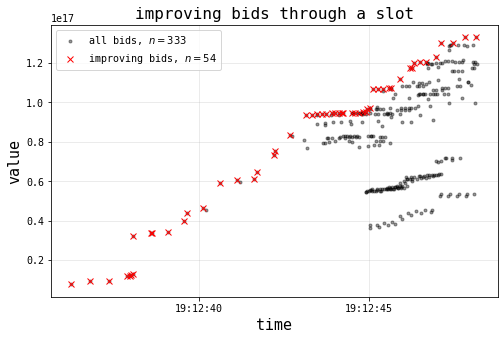

In [187]:
f, ax = plt.subplots(figsize=(8,5))
ax.plot(ssubs['received_at'], ssubs['value'], '.', label='all bids, $n={}$'.format(len(ssubs)), color='k', alpha=0.4)
ax.plot(toppts[:,0], toppts[:,1], 'x', label='improving bids, $n={}$'.format(incBids), color='r')

ax.set_xlabel('time', size=15)
ax.set_ylabel('value', size=15)
ax.set_title('improving bids through a slot', size=16)
plt.legend()
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(8,5))
ax.plot(ssubs['received_at'], ssubs['value'], '.', label='all bids, $n={}$'.format(len(ssubs)), color='k', alpha=0.4)
ax.plot(toppts[:,0], toppts[:,1], 'x', label='improving bids, $n={}$'.format(incBids), color='r')

ax.set_xlabel('time', size=15)
ax.set_ylabel('value', size=15)
ax.set_title('improving bids through a slot', size=16)
plt.legend()
plt.show()

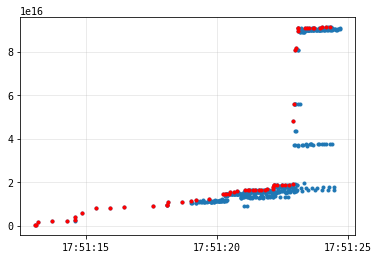

In [140]:
plt.plot(ssubs['received_at'], ssubs['value'], '.')
plt.plot(toppts[:,0], toppts[:,1], 'r.')